In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
np.set_printoptions(precision=2, linewidth=120)
from copy import copy
from tqdm import *
from drift_qec.Q import *

/Users/yan/.miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Regime 1 basis alignment

In [52]:
D = 0.25*np.pi
N_TRIALS = 100
MAX_N = int(1e6)
N_STEP = int(1e3)
RECORDS = []
for trial in tqdm(range(N_TRIALS)):
    channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                      Q=np.linalg.qr(np.random.randn(3,3))[0],
                      n=N_STEP, d=D)
    pxhat, pyhat, pzhat = list(np.linalg.svd(channel.Mhat)[1])
    RECORDS.append({
            "trial": trial,
            "time": 0,
            "d": channel.d,
            "Mdist": np.linalg.norm(channel.Mhat-channel.C),
            "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
            "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
            "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
        })
    for time in range(0, MAX_N, N_STEP):
        channel.update()
        pxhat, pyhat, pzhat = list(np.linalg.svd(channel.Mhat)[1])
        channel.d = np.min([pxhat, pyhat, pzhat])
        RECORDS.append({
                "trial": trial,
                "time": time,
                "d": channel.d,
                "Mdist": np.linalg.norm(channel.Mhat-channel.C),
                "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
                "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
                "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
            })

df = pd.DataFrame(RECORDS)
df.to_csv("regime1_adaptive_delta.csv")

In [53]:
D = 0.25*np.pi
N_TRIALS = 100
MAX_N = int(1e6)
N_STEP = int(1e3)
RECORDS = []
for trial in tqdm(range(N_TRIALS)):
    channel = Channel(kx=0.985, ky=0.01, kz=0.005,
                      Q=np.linalg.qr(np.random.randn(3,3))[0],
                      n=N_STEP, d=D)
    pxhat, pyhat, pzhat = list(np.linalg.svd(channel.Mhat)[1])
    RECORDS.append({
            "trial": trial,
            "time": 0,
            "d": channel.d,
            "Mdist": np.linalg.norm(channel.Mhat-channel.C),
            "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
            "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
            "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
        })
    for time in range(0, MAX_N, N_STEP):
        channel.update()
        pxhat, pyhat, pzhat = list(np.linalg.svd(channel.Mhat)[1])
        channel.d = np.min([pxhat, pyhat, pzhat])
        RECORDS.append({
                "trial": trial,
                "time": time,
                "d": channel.d,
                "Mdist": np.linalg.norm(channel.Mhat-channel.C),
                "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
                "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
                "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
            })

df = pd.DataFrame(RECORDS)
df.to_csv("regime2_adaptive_delta.csv")

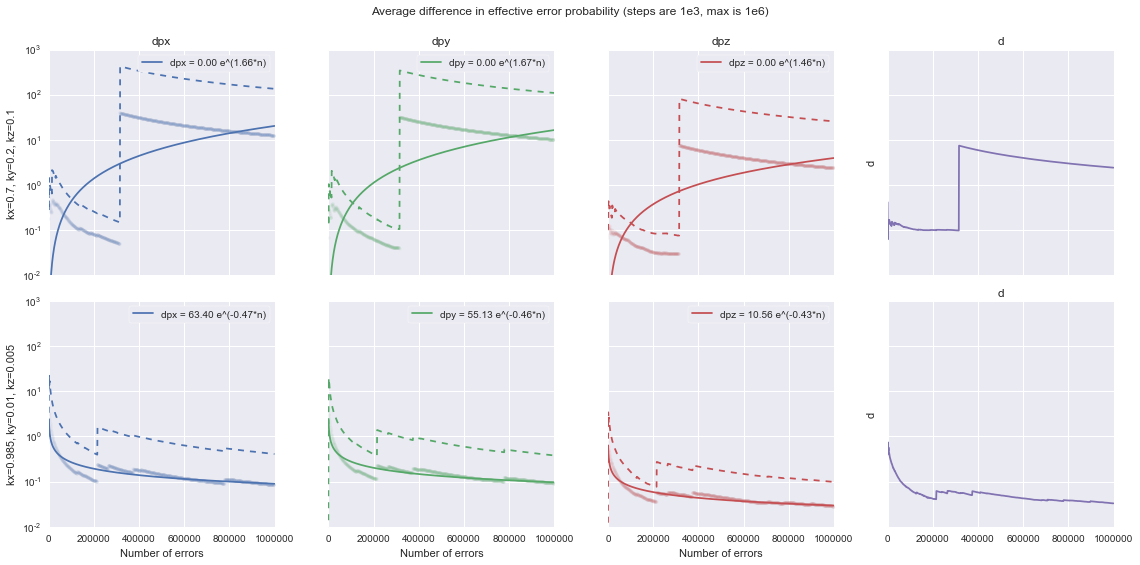

In [54]:
df1 = pd.read_csv("regime1_adaptive_delta.csv")
df1["dpx"] = np.abs(df1["pxval"] - df1["pxhat"])
df1["dpy"] = np.abs(df1["pyval"] - df1["pyhat"])
df1["dpz"] = np.abs(df1["pzval"] - df1["pzhat"])

v1 = df1.groupby("time").mean()
s1 = df1.groupby("time").std()

df2 = pd.read_csv("regime2_adaptive_delta.csv")
df2["dpx"] = np.abs(df2["pxval"] - df2["pxhat"])
df2["dpy"] = np.abs(df2["pyval"] - df2["pyhat"])
df2["dpz"] = np.abs(df2["pzval"] - df2["pzhat"])

v2 = df2.groupby("time").mean()
s2 = df2.groupby("time").std()


fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharey=True, sharex=True,
                        tight_layout={"h_pad": 1.0, "rect": [0.0, 0.0, 1.0, 0.95]})
for idx, stat in enumerate(["dpx", "dpy", "dpz"]):
    t1 = v1[stat].index.values
    y1 = v1[stat].values
    e1 = s1[stat].values
    x = np.log(v1.loc[1:, stat].index.values)
    y = np.log(v1.loc[1:, stat].values)
    reg = sp.stats.linregress(x, y)
    fitted = np.exp(reg.intercept + reg.slope * x)
    axs[0, idx].semilogy(t1, y1, ls="", marker=".", color=sns.color_palette()[idx], alpha=0.05)
    axs[0, idx].semilogy(t1, y1+e1, ls="--", color=sns.color_palette()[idx])
    axs[0, idx].semilogy(t1[1:], fitted, ls="-", color=sns.color_palette()[idx],
                         label="{} = {:0.2f} e^({:0.2f}*n)".format(stat, np.exp(reg.intercept), reg.slope))
    axs[0, idx].set_title(stat)
    axs[0, idx].legend(frameon=True)
    
    t2 = v2[stat].index.values
    y2 = v2[stat].values
    e2 = s2[stat].values
    x = np.log(v2.loc[1:, stat].index.values)
    y = np.log(v2.loc[1:, stat].values)
    reg = sp.stats.linregress(x, y)
    fitted = np.exp(reg.intercept + reg.slope * x)
    axs[1, idx].semilogy(t2, y2, ls="", marker=".", color=sns.color_palette()[idx], alpha=0.05)
    axs[1, idx].semilogy(t2, y2+e2, ls="--", color=sns.color_palette()[idx])
    axs[1, idx].semilogy(t2[1:], fitted, ls="-", color=sns.color_palette()[idx],
                         label="{} = {:0.2f} e^({:0.2f}*n)".format(stat, np.exp(reg.intercept), reg.slope))
    axs[1, idx].set_xlabel("Number of errors")
    axs[1, idx].legend(frameon=True)

fig.suptitle("Average difference in effective error probability (steps are 1e3, max is 1e6)")
axs[0, 0].set_ylabel("kx=0.7, ky=0.2, kz=0.1")
axs[1, 0].set_ylabel("kx=0.985, ky=0.01, kz=0.005")

axs[0, 3].semilogy(v1["d"].index.values, v1["d"].values, color=sns.color_palette()[3])
axs[1, 3].semilogy(v2["d"].index.values, v2["d"].values, color=sns.color_palette()[3])

axs[1, 3].set_title("d")
axs[0, 3].set_title("d")

axs[1, 3].set_ylabel("d")
axs[0, 3].set_ylabel("d")

fig.savefig("adaptivedelta_1e3_1e6.pdf")

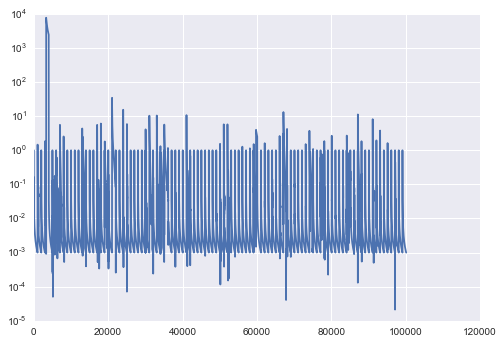

In [60]:
plt.semilogy(np.abs(df1["pxhat"] + df1["pyhat"] + df1["pzhat"] - 1.0))